## Store Item Demand Forecasting Challenge

Koristimo CRISP - DM metodologiju:

- Razumevanje poslovnog problema (eng. Business understanding)
- Razumevanje podataka (eng. Data understanding)
- Priprema podataka (eng. Data transformation)
- Modelovanje rešenja (eng. Modeling)
- Evaluacija rešenja (eng. Evaluation)
- Primena rešenja (eng. Deployment)

## Razumevanje problema

- Podaci u prodaji su prikupljani 5 godina
- 50 proizvoda u 10 različitih radnji
- Zadatak je predvideti("forecast-ovati") prodaju za naredna 3 meseca

Šta je vremenska serija?

Vremenska serija je niz opservacija prikupljenih u nekom vremenskom intervalu. Veoma je bitno naglasiti ulogu vremena ovde. Opservacije zavise od vremena kada se prikupljaju. 

## Razumevanje podataka

- Na početku ćemo napisati sve biblioteke potrebne za rad. Ukoliko neku zaboravimo dopisaćemo je kasnije

Osnovne python biblioteke koje se koriste u mašinskom učenju:

- pandas - python biblioteka koja služi za rad sa skupovima podataka (datasetovima)
- numpy - python biblioteka pogodna za različite kalkulacije
- scikit-learn - python biblioteka koja služi za modelovanje
- matplotlib i seaborn - python biblioteke koja služi za vizualizaciju (razne grafikone)

Ukoliko pri učitavanju neka biblioteka ne postoji moramo da je instaliramo pomoću pip komande:

U notebook-u: !pip install scikit-learn

ili preko Command Prompta(terminala): pip install scikit-learn

Skup podataka za treniranje i testiranje preuzećemo odavde:

https://www.kaggle.com/c/demand-forecasting-kernels-only/overview

In [1]:
# Da bi rezultati uvek bili isti kada radimo sa istom arhitekturom neuronske mreže, neophodno je da definišemo nešto 
# što se zove seed; seed se definiše pre svih ostalih biblioteka.
from numpy.random import seed
seed(1)
import tensorflow as tf
tf.random.set_seed(2)

import pandas as pd   # učitavamo pandas biblioteku da bismo pročitali skup podataka za trening, pd je skraćenica
import seaborn as sns  # učitavamo seaborn biblioteku za vizualizaciju, sns je skraćenica
import matplotlib.pyplot as plt # učitavamo matplotlib biblioteku za vizualizaciju, plt je skraćenica
import numpy as np # učitavamo pandas biblioteku za različite računske operacije, rad sa matricama itd.

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

from numpy import array
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from keras import optimizers
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers.core import Dense, Activation, Dropout
from sklearn.metrics import mean_absolute_error

In [2]:
train_data = pd.read_csv("train.csv") # pd.read_csv - ovako čitamo csv fajl, iz pandas biblioteke pročitaj mi csv fajl

In [3]:
train_data.head()  # za prikaz prvih 5 redova dataseta

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


- train_data.tail() prikazuje poslednjih 5 redova dataseta
- možemo napisati koliko redova želimo da nam se prikaže tako što ćemo u zagradu staviti broj redova npr. train_data.head(20) za prikaza prvih 20 redova


- Previđamo kolonu sales, cilj je da predvidimo koliko će se proizvoda prodati u naredna 3 meseca.

Kolone:
    
- date - datum kada je zabeležena prodaja proizvoda
- store - jedinstvena oznaka(id) prodavnice 
- item - jedinstvena oznaka(id) proizvoda
- sales - broj prodatih proizvoda

In [4]:
train_data.columns  # ovako prikazujemo sve kolone

Index(['date', 'store', 'item', 'sales'], dtype='object')

In [5]:
train_data.dtypes   # proveravamo tipove podataka

date     object
store     int64
item      int64
sales     int64
dtype: object

- ovo je bitno npr. ukoliko je datum kategorička vrednost (tip object) da je pretvorimo u datumski tip
- pretvaranje se radi na sledeći način ukoliko imamo date kolonu:

train_data['date_column'] = pd.to_datetime(train_data['date_column'])

Ukoliko želimo da pretvorimo object vrednost u tip integer (ceo broj) ili tip float (decimalni broj) to radimo na sledeći način:

train_data['kolona_koju_pretvaramo'] = train_data['kolona_koju_pretvaramo'].astype(int)

train_data['kolona_koju_pretvaramo'] = train_data['kolona_koju_pretvaramo'].astype(float)

- S obzirom da je datum kategorička vrednost, pretvorićemo ga u datumski tip

In [6]:
train_data['date'] = pd.to_datetime(train_data['date'])

In [7]:
train_data.dtypes # datum više nije tip object 

date     datetime64[ns]
store             int64
item              int64
sales             int64
dtype: object

- Proveravamo da li postoje nedostajuće vrednosti. Kao što možemo videti ne postoje nedostajuće vrednosti ni ma trening ni na test skupu

In [8]:
train_data.isnull().sum()  # proveravamo broj nedostajućih vrednosti na celom skupu podataka za sve atribute (feature)

date     0
store    0
item     0
sales    0
dtype: int64

In [9]:
train_data.shape   # broj redova je 913 000, broj kolona je 4

(913000, 4)

In [10]:
train_data.describe()  # deskriptivna statistika (samo numeričke vrednosti)

,store,item,sales
count,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,52.250287
std,2.872283,14.430878,28.801144
min,1.000000,1.000000,0.000000
25%,3.000000,13.000000,30.000000
50%,5.500000,25.500000,47.000000
75%,8.000000,38.000000,70.000000
max,10.000000,50.000000,231.000000


In [11]:
print('Max sale:', train_data.sales.max())  
print('Min sale:', train_data.sales.min())
print('Avg sale:', round(train_data.sales.mean(),2))

Max sale: 231
Min sale: 0
Avg sale: 52.25


In [12]:
print('Minimalni datum trening seta:', train_data['date'].min().date())
print('Maksimalni datum trening seta:', train_data['date'].max().date())

Minimalni datum trening seta: 2013-01-01
Maksimalni datum trening seta: 2017-12-31


## Vizualizacije

In [13]:
sales_pivoted_df = pd.pivot_table(train_data,
                                  index='store',
                                  values=['sales','date'],
                                  columns='item', 
                                  aggfunc=np.mean)

In [14]:
sales_pivoted_df['avg_sale'] = sales_pivoted_df.apply(lambda r: r.mean(), axis=1)

In [15]:
sales_pivoted_df

sales                                                         \
item           1          2          3          4          5          6   
store                                                                     
1      19.971522  53.148959  33.208105  19.956188  16.612815  53.060789   
2      28.173604  75.316539  46.992333  28.234940  23.540526  74.945235   
3      25.070099  66.804491  41.771084  25.116101  20.857612  67.007119   
4      22.938664  61.715225  38.548193  23.086528  19.525192  61.270537   
5      16.739321  44.488499  27.835706  16.776561  14.086528  44.564622   
6      16.717963  44.533954  27.811062  16.754107  13.893209  44.503834   
7      15.159365  40.717963  25.531216  15.358160  12.733844  40.703724   
8      26.983571  71.656627  45.076123  26.948521  22.427711  71.958379   
9      23.325849  61.792442  38.535049  23.150055  19.272180  61.412377   
10     24.736035  65.566813  41.113363  24.721249  20.637459  65.612267   

                                                   ...                        \
item           7          8          9         10  ...         42         43   
store                                              ...                         
1      52.783680  69.472070  46.504929  66.354326  ...  33.105696  46.242607   
2      75.058598  99.090361  65.478094  94.097481  ...  47.368018  65.785323   
3      66.647864  87.517525  58.486857  83.387733  ...  41.797371  58.197700   
4      61.625411  80.819825  54.043812  77.047645  ...  38.539978  54.018620   
5      44.535597  58.565717  38.837349  55.509858  ...  27.730559  39.163198   
6      44.599124  58.385542  39.460022  55.565170  ...  27.893209  39.034502   
7      40.709748  53.723987  35.901972  51.156627  ...  25.435926  35.426068   
8      71.730559  94.461117  63.193319  89.818182  ...  45.144031  62.980285   
9      61.812158  81.287514  54.105696  77.105148  ...  38.643483  54.152793   
10     65.807777  86.176889  57.886637  82.232202  ...  41.222892  57.942497   

                                                                          \
item          44          45         46         47         48         49   
store                                                                      
1      26.594195   72.720701  52.845016  19.814348  46.546002  26.461665   
2      37.785871  103.381161  75.219606  28.187842  66.028478  37.711939   
3      33.386090   91.851041  66.748083  25.120482  58.700986  33.259584   
4      30.952355   84.687295  61.420044  23.114458  53.765608  30.840635   
5      22.415115   61.427163  44.734940  16.699343  39.281490  22.371851   
6      22.322563   61.142935  44.539978  16.708653  39.052574  22.181271   
7      20.446331   55.905805  40.828587  15.479189  35.624315  20.406353   
8      36.194414   98.941402  72.004929  27.150055  62.737130  36.035049   
9      30.968237   85.093647  62.010953  23.003286  53.976999  31.052574   
10     32.916758   90.690581  66.046550  24.755750  57.814896  33.032311   

                   avg_sale  
item          50             
store                        
1      59.342826  47.268379  
2      84.622125  67.033165  
3      74.958379  59.530602  
4      68.921687  54.902946  
5      50.319277  39.770164  
6      50.516429  39.733516  
7      45.823658  36.363735  
8      80.972070  64.142048  
9      69.308324  55.049025  
10     74.037240  58.709288  

[10 rows x 51 columns]

### Prosečna prodaja u svakoj prodavnici

In [16]:
sales_store_data = go.Scatter(
    y = sales_pivoted_df.avg_sale.values,
    mode='markers',
    marker=dict(
        size = sales_pivoted_df.avg_sale.values,
        color = sales_pivoted_df.avg_sale.values,
        showscale=True
    ),
    text = sales_pivoted_df.index.values
)
data = [sales_store_data]

sales_store_layout = go.Layout(
    title= 'Prikaz prosečne prodaje u svakoj prodavnici',
    xaxis= dict(title='Prodavnice'),
    yaxis=dict(title='Prosečna prodaja')
)
fig = go.Figure(data=data, layout=sales_store_layout)
py.iplot(fig,filename='scatter_sales_store')

- Sa grafikona vidimo da je najveća prosečna prodaja zabeležena u prodavnicama 2 i 8, dok je najmanja zabeležena u prodavnici 7.

### Vizualizacija vremenske serije

In [17]:
train_data = train_data.sort_values(by='date')  # sortiramo vrednosti, ukoliko već nisu sortirane od najranijeg do
                                                # najkasnijeg datuma

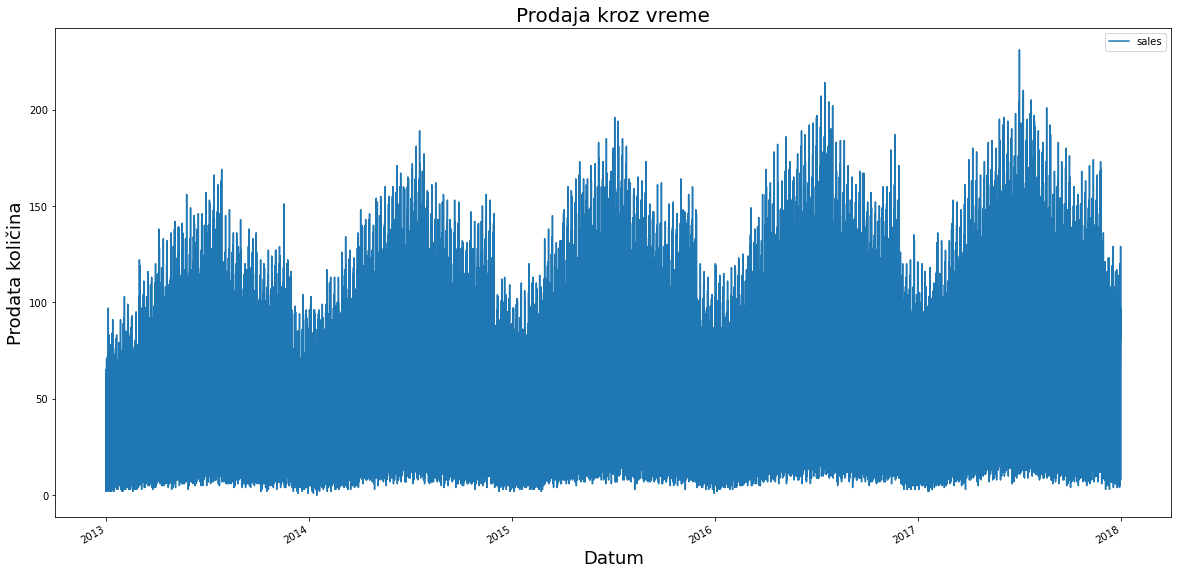

In [18]:
train_data.plot(x='date', y='sales', figsize=(20,10))
plt.xlabel("Datum", fontsize=18)
plt.ylabel("Prodata količina", fontsize=18)
plt.title('Prodaja kroz vreme', fontsize=20);

- Posmatrajući grafikon možemo uočiti patern. Prodaja se iz godine u godinu povećava u letnjim mesecima (jun, jul i avgust) dok se smanjuje u zimskim mesecima (decembar, januar i februar)

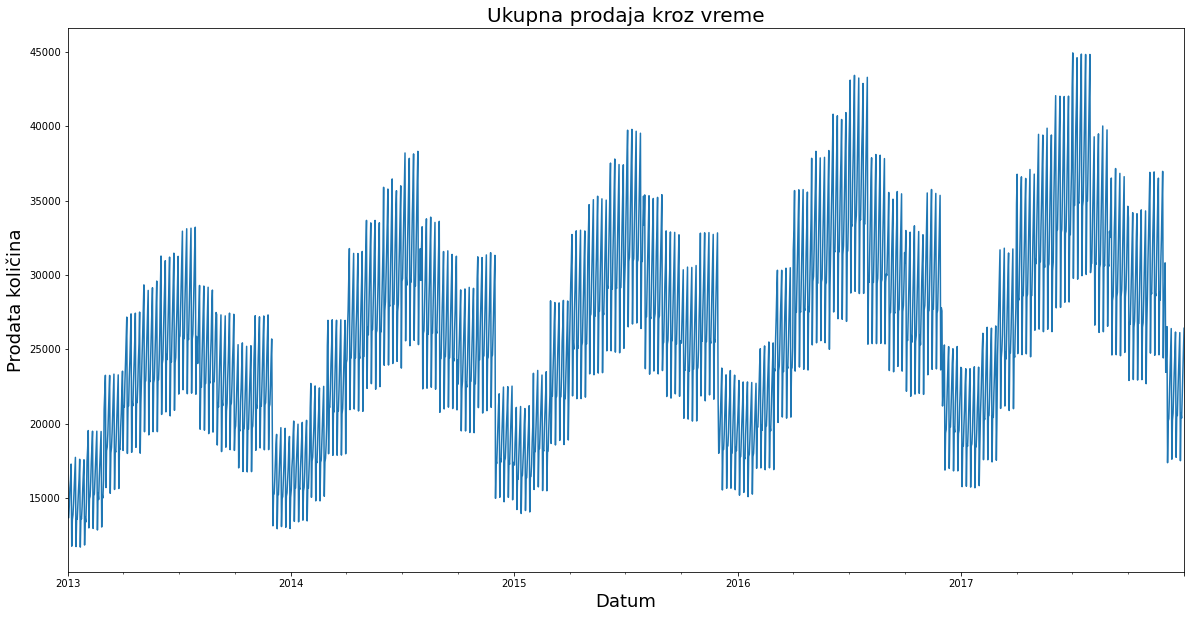

In [19]:
daily_sales = train_data.groupby('date')['sales'].sum()

daily_sales.plot(x='date', y='sales', figsize=(20,10))
plt.xlabel("Datum", fontsize=18)
plt.ylabel("Prodata količina", fontsize=18)
plt.title('Ukupna prodaja kroz vreme', fontsize=20);

In [20]:
daily_sales.head()

date
2013-01-01    13696
2013-01-02    13678
2013-01-03    14488
2013-01-04    15677
2013-01-05    16237
Name: sales, dtype: int64

## Priprema podataka

In [21]:
train_data.head()

,date,store,item,sales
0,2013-01-01,1,1,13
211816,2013-01-01,7,12,26
832656,2013-01-01,7,46,27
213642,2013-01-01,8,12,54
215468,2013-01-01,9,12,35


- Što imamo više podataka, to duže traje treniranje neuronske mreže. Iz tog razloga podatke ćemo agregirati na mesečni
nivo i zanemariti pojedinačne prodavnice i proizvode. Najpre moramo napraviti novu kolonu date, od naše stare kolone date na sledeći način: 

Iz skupa podataka train_data izaberi kolonu date, uzmi samo godinu, i pretvori je u string odnosno tekstualni tip.

train_data['date'].dt.year.astype('str')

Rezultat je npr. 2013

Zatim dodajemo crticu nakon godine i sada je rezultat 2013-

Na identičan način kako smo izvukli godinu izvlačimo i mesec, samo ćemo umesto dt.year, u ovom slučaju napisati dt.month

train_data['date'].dt.month.astype('str')

Rezultat je za sada 2013-01 

Poslednji korak je da uvek dodamo prvi dan u mesecu. Bez obzira na to kog dana u mesecu se desila prodaja svi datumi nekog meseca će biti prepravljeni na prvi u mesecu.

Rezultat nakog ovoga će biti 2013-01-01


Ovaj proces se zove konkatenacija stringova, odnosno sabiranje tekstualnih vrednosti korišćenjem operatora +.

In [22]:
train_data['date'] = train_data['date'].dt.year.astype('str') + '-' + train_data['date'].dt.month.astype('str') + '-01'


- S obzirom da želimo da radimo sa datumskim vrednostima, a ne sa stringovima, pretvorićemo date kolonu u datum.

In [23]:
train_data['date'] = pd.to_datetime(train_data['date'])

- Sada ćemo agregirati sve vrednosti prodaje na mesečni nivo. To možemo da uradimo na dva načina:
    
Prvi način:

train_data.groupby('date').agg({'sales': 'sum'})

Drugi način:

train_data.groupby('date').sales.sum()

In [24]:
train_data = train_data.groupby('date').agg({'sales': 'sum'})

In [25]:
train_data

,sales
date,
2013-01-01,454904
2013-02-01,459417
2013-03-01,617382
2013-04-01,682274
2013-05-01,763242
2013-06-01,795597
2013-07-01,855922
2013-08-01,766761
2013-09-01,689907


- Koristićemo 12 meseci za validaciju, a ostalo za trening

In [26]:
train = train_data[:-12]   # ovo znači da uzimamo sve redove osim poslednjih 12 (svi redovi -12 poslednjih)

validation = train_data[-12:] # ovo znači da uzimamo samo poslednjih 12 redova (od -12 poslednjih redova do kraja)

In [27]:
train.head()

,sales
date,
2013-01-01,454904
2013-02-01,459417
2013-03-01,617382
2013-04-01,682274
2013-05-01,763242


In [28]:
validation.head()

,sales
date,
2017-01-01,617306
2017-02-01,621369
2017-03-01,822667
2017-04-01,938862
2017-05-01,1020686


## Modelovanje rešenja

- Podaci se skaliraju. Mnogi algoritmi mašinskog učenja imaju bolje performanse ukoliko su varijable skalirane u određenom rangu vrednosti. 
- Skaliranje se radi i kada su kolone odnosno feature-i koje koristimo u našem modelu izraženi u različitim mernim jednicama (npr. kilometri, sati) što znači da različite kolone imaju različite skale.

MinMaxScaler() transformiše svaku vrednost u koloni proporcionalno u rangu vrednosti [0, 1]

In [29]:
scaler = MinMaxScaler()
scaler.fit(train)
train = scaler.transform(train)
validation = scaler.transform(validation)

- Podaci vremenske serije moraju da se transformišu u takvu strukturu koja će biti pogodna za treniranje modela. Keras, deep learning biblioteka obezbeđuje nam TimeseriesGenerator koji radi automatsku transformaciju podataka u takav oblik koji je pogodan za treniranje deep learning modela. 

In [30]:
n_input = 12    # koliko da posmatramo meseci unazad
n_features = 1  # koliko imamo ulaznih kolona(feature-a)
batch_size = 6  # broj instanci koje se vraćaju u svakoj iteraciji
generator = TimeseriesGenerator(train, train, length=n_input, batch_size=batch_size) 

- Sada definišemo arhitekturu neuronske mreže

- Sekvencijalni model je jednostavna lista slojeva, koristi se za inicijalizaciju mreže
- Najpre imamo konvolucioni sloj of 64 filtera, koji predstavljaju broj. neurona, zatim kernel dimenzije 2
Napomena: Conv2D se koristi za slike dok se Conv1D koristi za vremenske serije
- Za konvolucione neuronske mreže se najčešćee koristi relu aktivaciona funkcija
- Dodajemo MaxPooling layer za smanjenje dimenzionalnosti i lakšu primenu računskih operacija
- Flatten je funkcija koja pretvara feature mapu (output svakog sloja konvolucione mreže) u jednu kolonu koja se kasnije prosleđuje potpuno povezanom sloju (fully conected layer)
- Dense dodaje potpuno povezane slojeve (fully connected layer) u neuronsku mrežu
- Zatim se neuronska mreža kompajlira. Compile funkcija ima kao parametre loss funkciju koja je naješće mae ili mse,
i optimizer, najčešće adam koji primenjuje Adam optimization. To je metoda gradijentnog spusta.  

In [31]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_input, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 11, 64)            192       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 5, 64)             0         
_________________________________________________________________
flatten (Flatten)            (None, 320)               0         
_________________________________________________________________
dense (Dense)                (None, 50)                16050     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 16,293
Trainable params: 16,293
Non-trainable params: 0
_________________________________________________________________


- Radimo model fit, prosleđujemo generator, biramo 100 epoha. Ovo je opciono, broj epoha može u početku biti neki manji broj, npr. 10, i onda posmatramo grafikon ispod i gledamo kako model uči iz epohee u epohu. Ukoliko model u 
prvih 10 epoha dovoljno nauči, nema potrebe povećavati broj epoha. U suprotnom trebalo bi povećati broj epoha. Ovde treba voditi računa da broj epoha ne bude prevelik, što bi značilo da je model overfitovao odnosno da je pretreniran pa pokazuje dobre perfomanse na trening i validacionom skupu dok na podacima koje nikada pre nije video ima loše performanse. 

In [32]:
m = model.fit(generator,epochs=100)

Epoch 1/100
6/6 [==============================] - 0s 1ms/step - loss: 0.5001
Epoch 2/100
6/6 [==============================] - 0s 1ms/step - loss: 0.2440
Epoch 3/100
6/6 [==============================] - 0s 1ms/step - loss: 0.0975
Epoch 4/100
6/6 [==============================] - 0s 1ms/step - loss: 0.0624
Epoch 5/100
6/6 [==============================] - 0s 1ms/step - loss: 0.0674
Epoch 6/100
6/6 [==============================] - 0s 1ms/step - loss: 0.0573
Epoch 7/100
6/6 [==============================] - 0s 2ms/step - loss: 0.0486
Epoch 8/100
6/6 [==============================] - 0s 1ms/step - loss: 0.0376
Epoch 9/100
6/6 [==============================] - 0s 2ms/step - loss: 0.0375
Epoch 10/100
6/6 [==============================] - 0s 1ms/step - loss: 0.0324
Epoch 11/100
6/6 [==============================] - 0s 1ms/step - loss: 0.0248
Epoch 12/100
6/6 [==============================] - 0s 2ms/step - loss: 0.0215
Epoch 13/100
6/6 [==============================] - 0s 1ms/st

- Grafikon prikazuje kako model uči iz epohe u epohu i pokazuje nam kako odabrati optimalan broj epoha.

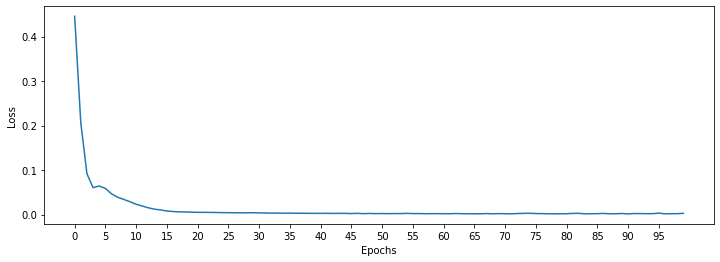

In [33]:
losses_lstm = model.history.history['loss']

plt.figure(figsize=(12,4))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(np.arange(0,100, 5))
plt.plot(range(len(losses_lstm)),losses_lstm);

- Napravi praznu listu za svaku od naših 12 predikcija
- Napravi seriju koju će model predviđati
- Sačuvaj predikciju u listu
- Dodaj predikciju na kraj serije i koristi je za sledeću predikciju

In [34]:
pred_list = []

batch = train[-n_input:].reshape((1, n_input, n_features)) # oblik podataka se poklapa sa input_shape modela

In [35]:
batch

array([[[0.21575311],
        [0.23405926],
        [0.49132805],
        [0.6537538 ],
        [0.78065965],
        [0.83028426],
        [1.        ],
        [0.77007783],
        [0.64626784],
        [0.5977254 ],
        [0.63839582],
        [0.30491771]]])

In [36]:
for i in range(n_input):   
    pred_list.append(model.predict(batch)[0]) 
    print(pred_list)
    print(batch[:,1:,:])
    batch = np.append(batch[:,1:,:],[[pred_list[i]]], axis=1)

[array([0.26245412], dtype=float32)]
[[[0.23405926]
  [0.49132805]
  [0.6537538 ]
  [0.78065965]
  [0.83028426]
  [1.        ]
  [0.77007783]
  [0.64626784]
  [0.5977254 ]
  [0.63839582]
  [0.30491771]]]
[array([0.26245412], dtype=float32), array([0.33428463], dtype=float32)]
[[[0.49132805]
  [0.6537538 ]
  [0.78065965]
  [0.83028426]
  [1.        ]
  [0.77007783]
  [0.64626784]
  [0.5977254 ]
  [0.63839582]
  [0.30491771]
  [0.26245412]]]
[array([0.26245412], dtype=float32), array([0.33428463], dtype=float32), array([0.5509833], dtype=float32)]
[[[0.6537538 ]
  [0.78065965]
  [0.83028426]
  [1.        ]
  [0.77007783]
  [0.64626784]
  [0.5977254 ]
  [0.63839582]
  [0.30491771]
  [0.26245412]
  [0.33428463]]]
[array([0.26245412], dtype=float32), array([0.33428463], dtype=float32), array([0.5509833], dtype=float32), array([0.76013666], dtype=float32)]
[[[0.78065965]
  [0.83028426]
  [1.        ]
  [0.77007783]
  [0.64626784]
  [0.5977254 ]
  [0.63839582]
  [0.30491771]
  [0.26245412]
  

In [37]:
batch

array([[[0.26245412],
        [0.33428463],
        [0.55098331],
        [0.76013666],
        [0.80837083],
        [0.96790868],
        [1.03109682],
        [0.87833571],
        [0.7129578 ],
        [0.74545133],
        [0.6862784 ],
        [0.37216735]]])

In [38]:
df_predict = pd.DataFrame(scaler.inverse_transform(pred_list),
                          index=train_data[-n_input:].index, columns=['Prediction'])

df_test = pd.concat([train_data, df_predict], axis=1)

In [39]:
df_predict

,Prediction
date,
2017-01-01,6.343738e+05
2017-02-01,6.834925e+05
2017-03-01,8.316741e+05
2017-04-01,9.746961e+05
2017-05-01,1.007679e+06
2017-06-01,1.116774e+06
2017-07-01,1.159982e+06
2017-08-01,1.055522e+06
2017-09-01,9.424345e+05


In [40]:
df_test

,sales,Prediction
date,,
2013-01-01,454904,NaN
2013-02-01,459417,NaN
2013-03-01,617382,NaN
2013-04-01,682274,NaN
2013-05-01,763242,NaN
2013-06-01,795597,NaN
2013-07-01,855922,NaN
2013-08-01,766761,NaN
2013-09-01,689907,NaN


- Na grafikonu su crvenom bojom prikazane stvarne vrednosti prodaje, dok su plavom predviđene realne vrednosti za 2017. godinu. Kao što možemo primetiti algoritam je uspeo da uhvati patern vremenske serije tj. predviđena vrednost se dobro poklopila sa stvarnom vrednošću. 

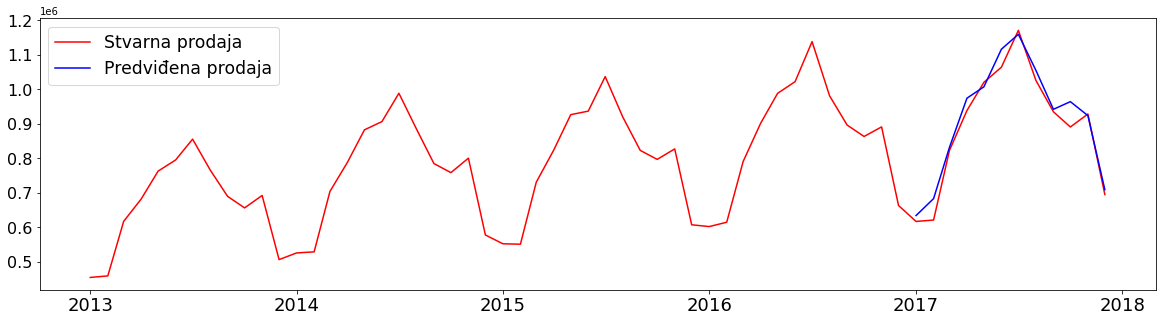

In [41]:
plt.figure(figsize=(20, 5))
plt.plot(df_test.index, df_test['sales'], color='r')
plt.plot(df_test.index, df_test['Prediction'], color='b')
plt.legend(["Stvarna prodaja", "Predviđena prodaja"], loc='best', fontsize='xx-large')
plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.show()

## Evalucija rešenja

- Za evaluaciju se koristi root mean squared error. Pored ove evaluacione metrike može se koristiti i mean squared error kao i metrike koje su klijentima lakše za razumevanje kao što je npr. procentualno odstupanje predviđene od stvarne greške.

In [42]:
pred_actual_rmse = rmse(df_test.iloc[-n_input:, [0]], df_test.iloc[-n_input:, [1]])
print("rmse: ", pred_actual_rmse)

rmse:  [35425.43499377]


## Primena rešenja

- Sledi primena rešenja na periodu koji model nikada nije video, odnosno 12 meseci 2018. godine.

In [43]:
train = train_data

In [44]:
scaler.fit(train)
train = scaler.transform(train)

In [45]:
n_input = 12
n_features = 1
generator = TimeseriesGenerator(train, train, length=n_input, batch_size=6)

In [46]:
model.fit(generator,epochs=100)

Epoch 1/100
8/8 [==============================] - 0s 1ms/step - loss: 0.0021
Epoch 2/100
8/8 [==============================] - 0s 1ms/step - loss: 0.0014
Epoch 3/100
8/8 [==============================] - 0s 1ms/step - loss: 0.0016
Epoch 4/100
8/8 [==============================] - 0s 1ms/step - loss: 0.0015
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 0.0014
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 0.0015
Epoch 7/100
8/8 [==============================] - 0s 1ms/step - loss: 0.0015
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 0.0017
Epoch 9/100
8/8 [==============================] - 0s 1ms/step - loss: 0.0019
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 0.0021
Epoch 11/100
8/8 [==============================] - 0s 1ms/step - loss: 0.0017
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 0.0012
Epoch 13/100
8/8 [==============================] - 0s 2ms/st

In [47]:
pred_list = []

batch = train[-n_input:].reshape((1, n_input, n_features))

for i in range(n_input):   
    pred_list.append(model.predict(batch)[0]) 
    batch = np.append(batch[:,1:,:],[[pred_list[i]]],axis=1)

In [48]:
from pandas.tseries.offsets import DateOffset
add_dates = [train_data.index[-1] + DateOffset(months=x) for x in range(0,13)]
future_dates = pd.DataFrame(index=add_dates[1:],columns=train_data.columns)

In [49]:
df_predict = pd.DataFrame(scaler.inverse_transform(pred_list),
                          index=future_dates[-n_input:].index, columns=['Prediction'])

df_proj = pd.concat([train_data, df_predict], axis=1)

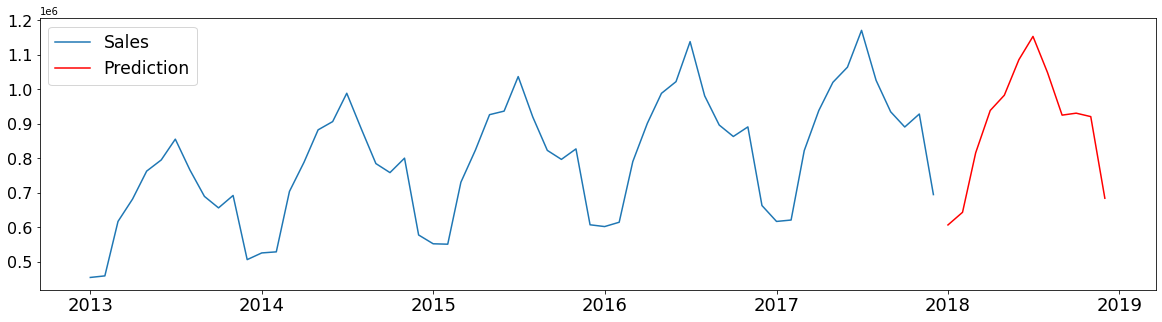

In [50]:
plt.figure(figsize=(20, 5))
plt.plot(df_proj.index, df_proj['sales'])
plt.plot(df_proj.index, df_proj['Prediction'], color='r')
plt.legend(["Sales", "Prediction"], loc='best', fontsize='xx-large')
plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.show()

In [55]:
df_proj

,sales,Prediction
2013-01-01,454904.0,NaN
2013-02-01,459417.0,NaN
2013-03-01,617382.0,NaN
2013-04-01,682274.0,NaN
2013-05-01,763242.0,NaN
...,...,...
2018-08-01,NaN,1.075003e+06
2018-09-01,NaN,9.497384e+05
2018-10-01,NaN,9.515664e+05
2018-11-01,NaN,9.348228e+05
